In [0]:
# F1 Race Position Prediction Model
# ================================
# Author: Aria Narang
# Date: April 4, 2025
# Project: Applied Data Science Take Home Excercise #3
# Datasets used: raw/races.csv, raw/results.csv, raw/qualifying.csv, raw/drivers.csv
#
# This notebook builds a Random Forest Regression model to predict F1 race finishing
# positions.
#
#
# I track multiple experiments with MLflow, varying the following hyperparameters:
# - n_estimators (number of trees)
# - max_depth (tree depth)
# - min_samples_split (minimum samples for a node split)
# - min_samples_leaf (minimum samples for a leaf node)
# - max_features (number of features to consider for best split)
#
# After comparing 10 different hyperparameter configurations, I select the best model
# based on lowest RMSE (Root Mean Squared Error) and highest R² score.

In [0]:
# Install mlflow
!pip install mlflow



Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from datetime import datetime
import os

In [0]:
# Load races data
races_df = spark.read.csv('s3://columbia-gr5069-main/raw/races.csv', header=True, inferSchema=True)
# Convert to Pandas for easier data manipulation
races = races_df.toPandas()
print("Races columns:", races.columns.tolist())

# Load results data
results_df = spark.read.csv('s3://columbia-gr5069-main/raw/results.csv', header=True, inferSchema=True)
results = results_df.toPandas()
print("Results columns:", results.columns.tolist())

# Load qualifying data
qualifying_df = spark.read.csv('s3://columbia-gr5069-main/raw/qualifying.csv', header=True, inferSchema=True)
qualifying = qualifying_df.toPandas()
print("Qualifying columns:", qualifying.columns.tolist())

# Load drivers data
drivers_df = spark.read.csv('s3://columbia-gr5069-main/raw/drivers.csv', header=True, inferSchema=True)
drivers = drivers_df.toPandas()
print("Drivers columns:", drivers.columns.tolist())

Races columns: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
Results columns: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']
Qualifying columns: ['qualifyId', 'raceId', 'driverId', 'constructorId', 'number', 'position', 'q1', 'q2', 'q3']
Drivers columns: ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']


In [0]:
#Data preparation
def prepare_dataset(races, results, qualifying, drivers):
    """
    Merges and prepares data for modeling
    """
    # Create feature dataframe by merging datasets
    # Join qualifying data with results
    df = pd.merge(qualifying[['raceId', 'driverId', 'position']], 
                  results[['raceId', 'driverId', 'position', 'grid', 'statusId']], 
                  on=['raceId', 'driverId'], 
                  suffixes=('_quali', ''))
    
    # Add race information 
    df = pd.merge(df, races[['raceId', 'year', 'round', 'circuitId']], on='raceId')
    
    # Add driver information
    # Calculate driver experience at time of race
    drivers_with_exp = drivers.copy()
    
    # Convert driver DOB to datetime
    drivers_with_exp['dob'] = pd.to_datetime(drivers_with_exp['dob'], errors='coerce')
    
    # Join with race date
    race_driver = pd.merge(
        df[['raceId', 'driverId']], 
        races[['raceId', 'date']], 
        on='raceId'
    )
    race_driver['date'] = pd.to_datetime(race_driver['date'], errors='coerce')
    race_driver = pd.merge(
        race_driver,
        drivers_with_exp[['driverId', 'dob']],
        on='driverId'
    )
    
    # Calculate age/experience at race time
    race_driver['experience_years'] = (race_driver['date'] - race_driver['dob']).dt.days / 365.25
    
    # Join back to main dataframe
    df = pd.merge(
        df,
        race_driver[['raceId', 'driverId', 'experience_years']],
        on=['raceId', 'driverId']
    )
    
    # Extract fastest lap information if available
    if 'fastestLapTime' in results.columns:
        fastest_lap_data = results[['raceId', 'driverId', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed']]
        df = pd.merge(df, fastest_lap_data, on=['raceId', 'driverId'], how='left')
    
    # Convert race position to numeric
    if 'position' in df.columns:
        df['position_result'] = pd.to_numeric(df['position'], errors='coerce')
    
    # Drop rows where position_result is missing or invalid
    df = df.dropna(subset=['position_result'])
    
    # Feature engineering
    # Calculate position difference from qualifying to race result
    df['position_change'] = df['position_quali'] - df['position_result']
    
    # Create binary feature for race completion 
    df['finished_race'] = (df['statusId'] == 1)
    
    # Convert qualifying times to seconds 
    for q_col in ['q1', 'q2', 'q3']:
        if q_col in qualifying.columns:
            q_times = qualifying[['raceId', 'driverId', q_col]].copy()
            df = pd.merge(df, q_times, on=['raceId', 'driverId'], how='left')
            
            # Convert time strings to seconds 
            if df[q_col].dtype == 'object':  
                def convert_time_to_seconds(time_str):
                    if pd.isna(time_str):
                        return np.nan
                    try:
                        if ':' in time_str:
                            mins, rest = time_str.split(':')
                            secs = float(mins) * 60 + float(rest)
                        else:
                            secs = float(time_str)
                        return secs
                    except:
                        return np.nan
                
                df[f'{q_col}_seconds'] = df[q_col].apply(convert_time_to_seconds)
    
    # Drop rows with missing values in key columns
    df = df.dropna(subset=['position_quali', 'position_result', 'grid', 'experience_years'])
    
    return df

In [0]:
# Call the prepare_dataset function and store the result in df
df = prepare_dataset(races, results, qualifying, drivers)

# Print a sample of the prepared dataset
print(f"Prepared dataset shape: {df.shape}")
display(df.head())

Prepared dataset shape: (7451, 22)


raceId,driverId,position_quali,position,grid,statusId,year,round,circuitId,experience_years,fastestLap,fastestLapTime,fastestLapSpeed,position_result,position_change,finished_race,q1,q1_seconds,q2,q2_seconds,q3,q3_seconds
18,1,1,1,1,1,2008,1,1,23.186858316221766,39,1:27.452,218.300,1.0,0.0,true,1:26.572,86.572,1:25.187,85.187,1:26.714,86.714
18,5,3,5,3,1,2008,1,1,26.406570841889117,43,1:27.418,218.385,5.0,-2.0,true,1:25.664,85.664,1:25.452,85.452,1:27.079,87.07900000000001
18,2,5,2,5,1,2008,1,1,30.850102669404517,41,1:27.739,217.586,2.0,3.0,true,1:25.960,85.96000000000001,1:25.518,85.518,1:27.236,87.236
18,3,7,3,7,1,2008,1,1,22.718685831622178,41,1:28.090,216.719,3.0,4.0,true,1:26.295,86.295,1:26.059,86.059,1:28.687,88.687
18,4,12,4,11,1,2008,1,1,26.63107460643395,58,1:28.603,215.464,4.0,8.0,true,1:26.907,86.907,1:26.188,86.188,\N,null


In [0]:
# After preparing the dataset

# Define features and target

X = df[['position_quali', 'grid', 'experience_years', 'round', 'year', 'circuitId', 'finished_race']]

# Add qualifying time features 
for col in df.columns:
    if col.endswith('_seconds'):
        X[col] = df[col]

# Add fastest lap features 
if 'fastestLapSpeed' in df.columns:
    X['fastestLapSpeed'] = df['fastestLapSpeed']

# Target variable: race finish position
y = df['position_result']

# Print shapes to verify data preparation
print(f"Feature dataset shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Handle problematic values
for col in X.columns:
    if X[col].dtype == object:  
        X[col] = X[col].replace('\\N', np.nan)
        
    # Try to convert to numeric
    if X[col].dtype == object:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Check for missing values
print("Columns with missing values:", X.isna().sum()[X.isna().sum() > 0])

# Drop rows with any missing values
X_clean = X.dropna()
y_clean = y.loc[X_clean.index] 

# Check shape after handling missing values
print(f"Feature dataset shape after cleaning: {X_clean.shape}")
print(f"Target variable shape after cleaning: {y_clean.shape}")

# Import ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import numpy as np

# Set up MLflow experiment
mlflow.set_experiment("/Users/an3016@columbia.edu/F1_Race_Position_Prediction")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Define your first model with some hyperparameters
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42
    ))
])

# Start MLflow tracking
with mlflow.start_run(run_name="Initial Model") as run:
    # Log parameters
    params = {
        "n_estimators": 100,
        "max_depth": 10,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_features": "sqrt",
        "random_state": 42
    }
    mlflow.log_params(params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Print metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Create and log artifacts
    
    # 1. Prediction vs Actual plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Race Position')
    plt.ylabel('Predicted Race Position')
    plt.title('Predicted vs Actual Race Position')
    plt.tight_layout()
    pred_plot_path = "/tmp/prediction_plot.png"
    plt.savefig(pred_plot_path)
    mlflow.log_artifact(pred_plot_path)
    plt.close()
    
    # 2. Feature Importance plot
    feature_importances = model.named_steps['regressor'].feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(X_clean.columns)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    imp_plot_path = "/tmp/feature_importance.png"
    plt.savefig(imp_plot_path)
    mlflow.log_artifact(imp_plot_path)
    plt.close()
    
    # 3. Save predictions CSV
    results_df = pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'abs_error': np.abs(y_test.values - y_pred)
    })
    pred_csv_path = "/tmp/predictions.csv"
    results_df.to_csv(pred_csv_path, index=False)
    mlflow.log_artifact(pred_csv_path)
    
    # Log the model
    mlflow.sklearn.log_model(model, "model")
    
    print(f"Run ID: {run.info.run_id}")
    print("Model training complete!")

/root/.ipykernel/1131/command-9004334233258056-1924523281:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = df[col]
/root/.ipykernel/1131/command-9004334233258056-1924523281:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = df[col]
/root/.ipykernel/1131/command-9004334233258056-1924523281:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Feature dataset shape: (7451, 11)
Target variable shape: (7451,)
Columns with missing values: q1_seconds           98
q2_seconds         2985
q3_seconds         4598
fastestLapSpeed    1030
dtype: int64
Feature dataset shape after cleaning: (2844, 11)
Target variable shape after cleaning: (2844,)
MSE: 5.9570
RMSE: 2.4407
MAE: 1.8278
R²: 0.5990


2025/04/04 15:27:34 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:27:34 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run ID: b50a6e8853f1465c8a63638921676f95
Model training complete!


In [0]:
# Run the experiments
# Define hyperparameter grid (10 different combinations)
param_grid = [
    {"n_estimators": 100, "max_depth": 10, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": 15, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 100, "max_depth": 20, "min_samples_split": 5, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 150, "max_depth": 15, "min_samples_split": 10, "min_samples_leaf": 4, "max_features": "log2"},
    {"n_estimators": 300, "max_depth": 10, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": 0.7},
    {"n_estimators": 100, "max_depth": 20, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": 0.5},
    {"n_estimators": 200, "max_depth": 15, "min_samples_split": 5, "min_samples_leaf": 2, "max_features": 0.6},
    {"n_estimators": 250, "max_depth": 12, "min_samples_split": 3, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 150, "max_depth": 8, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "log2"}
]

# Store results for later comparison
results = []

# Run all experiments
for i, params in enumerate(param_grid):
    print(f"Running experiment {i+1}/10 with parameters: {params}")
    
    # Create model with current parameters
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            min_samples_split=params["min_samples_split"],
            min_samples_leaf=params["min_samples_leaf"],
            max_features=params["max_features"],
            random_state=42
        ))
    ])
    
    # Start MLflow run
    with mlflow.start_run(run_name=f"Run {i+1}") as run:
        # Log parameters
        mlflow.log_params(params)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        # Store results
        results.append({
            "run_id": run.info.run_id,
            "params": params,
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "r2": r2
        })
        
        # Create and log artifacts
        
        # 1. Prediction vs Actual plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Race Position')
        plt.ylabel('Predicted Race Position')
        plt.title('Predicted vs Actual Race Position')
        plt.tight_layout()
        pred_plot_path = f"/tmp/prediction_plot_run{i+1}.png"
        plt.savefig(pred_plot_path)
        mlflow.log_artifact(pred_plot_path)
        plt.close()
        
        # 2. Feature Importance plot
        feature_importances = model.named_steps['regressor'].feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
        plt.yticks(range(len(sorted_idx)), np.array(X_clean.columns)[sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance')
        plt.tight_layout()
        imp_plot_path = f"/tmp/feature_importance_run{i+1}.png"
        plt.savefig(imp_plot_path)
        mlflow.log_artifact(imp_plot_path)
        plt.close()
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        print(f"Run {i+1} complete. RMSE: {rmse:.4f}, R²: {r2:.4f}")

Running experiment 1/10 with parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


2025/04/04 15:27:40 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:27:40 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 1 complete. RMSE: 2.4407, R²: 0.5990
Running experiment 2/10 with parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


2025/04/04 15:27:46 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:27:46 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 2 complete. RMSE: 2.4471, R²: 0.5969
Running experiment 3/10 with parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


2025/04/04 15:27:52 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:27:52 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 3 complete. RMSE: 2.4706, R²: 0.5891
Running experiment 4/10 with parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


2025/04/04 15:27:58 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:27:58 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 4 complete. RMSE: 2.4465, R²: 0.5970
Running experiment 5/10 with parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}


2025/04/04 15:28:04 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:28:04 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 5 complete. RMSE: 2.4702, R²: 0.5892
Running experiment 6/10 with parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7}


2025/04/04 15:28:12 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:28:12 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 6 complete. RMSE: 2.4388, R²: 0.5996
Running experiment 7/10 with parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}


2025/04/04 15:28:19 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:28:19 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 7 complete. RMSE: 2.4720, R²: 0.5886
Running experiment 8/10 with parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.6}


2025/04/04 15:28:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:28:26 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 8 complete. RMSE: 2.4477, R²: 0.5966
Running experiment 9/10 with parameters: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


2025/04/04 15:28:33 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:28:33 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 9 complete. RMSE: 2.4446, R²: 0.5977
Running experiment 10/10 with parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


2025/04/04 15:28:39 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/04 15:28:39 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run 10 complete. RMSE: 2.4366, R²: 0.6003


run_id,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,mse,rmse,mae,r2
d88d990ca1f34a119a0b0b964180e9f3,100,10,2,1,sqrt,5.956988844545126,2.440694336565955,1.8278381802660764,0.5989558296571849
d49dc1f9a5674c6aaf8a850ced356241,200,15,2,1,sqrt,5.988233599453018,2.4470867576473494,1.84662937828018,0.5968523295270688
7cfd53481df14c259214781d3757fb81,100,20,5,2,sqrt,6.103912210381039,2.4706096839405935,1.8576112445768223,0.5890644632481989
f3d058fb1f1a4c45801a4a00fcc6fc5a,200,None,2,1,sqrt,5.985457601054481,2.446519487160174,1.8469156414762742,0.5970392189108946
52a68a9e42a74f94948f2b52a804cc58,150,15,10,4,log2,6.101964964111726,2.4702155703727007,1.8485842727661752,0.5891955583005666
e0a2f56534334f89bd380198656c51c6,300,10,2,1,0.7,5.947737637654334,2.4387984003714482,1.8222950878668682,0.599578651470186
fdc7bd3cf5ff4f8f99f066c4df61fa07,100,20,2,1,0.5,6.110936905307672,2.472030927255497,1.8574172519838836,0.5885915375768099
7de3303306d34e5eb20a67016b559548,200,15,5,2,0.6,5.991470234805566,2.447747992503633,1.83817648658809,0.5966344285415981
4ade51c6404a47c2a840dd76c78e6af1,250,12,3,1,sqrt,5.9763064275511235,2.4446485284292145,1.8366247456153346,0.5976553061457529
a5b47749bf5f4351892a1d27736758a6,150,8,2,1,log2,5.937161133189323,2.436629051207697,1.8346636782475334,0.6002906966945415


<module 'matplotlib.pyplot' from '/databricks/python/lib/python3.11/site-packages/matplotlib/pyplot.py'>


Best model (Run 10):
Run ID: a5b47749bf5f4351892a1d27736758a6
RMSE: 2.4366
R²: 0.6003
Parameters: n_estimators=150, max_depth=8, min_samples_split=2, min_samples_leaf=1, max_features=log2


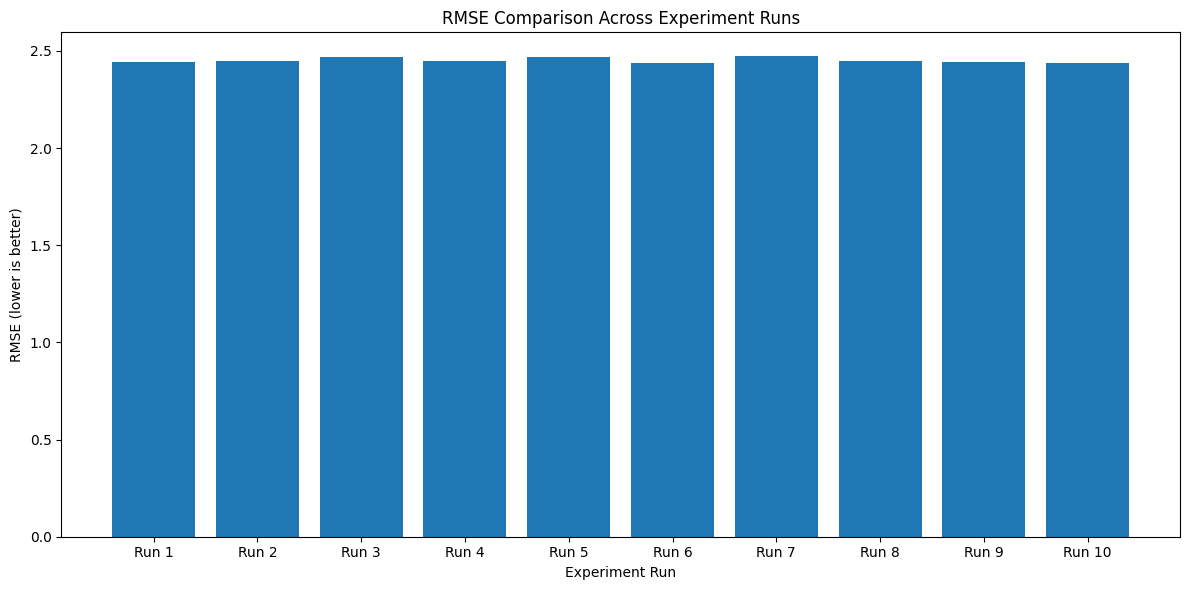

In [0]:
# Create summary dataframe
summary_df = pd.DataFrame([
    {
        "run_id": res["run_id"],
        "n_estimators": res["params"]["n_estimators"],
        "max_depth": str(res["params"]["max_depth"]),  # Handle None values
        "min_samples_split": res["params"]["min_samples_split"],
        "min_samples_leaf": res["params"]["min_samples_leaf"],
        "max_features": str(res["params"]["max_features"]),  # Handle different types
        "mse": res["mse"],
        "rmse": res["rmse"],
        "mae": res["mae"],
        "r2": res["r2"]
    } for res in results
])

# Display summary table
display(summary_df)

# Create comparison plots
plt.figure(figsize=(12, 6))
plt.bar(range(len(results)), [res["rmse"] for res in results])
plt.xlabel("Experiment Run")
plt.ylabel("RMSE (lower is better)")
plt.title("RMSE Comparison Across Experiment Runs")
plt.xticks(range(len(results)), [f"Run {i+1}" for i in range(len(results))])
plt.tight_layout()
comparison_plot_path = "/tmp/rmse_comparison.png"
plt.savefig(comparison_plot_path)
display(plt)

# Find best model by RMSE
best_idx = summary_df["rmse"].idxmin()
best_model = summary_df.iloc[best_idx]

print("\n" + "="*50)
print(f"Best model (Run {best_idx + 1}):")
print(f"Run ID: {best_model['run_id']}")
print(f"RMSE: {best_model['rmse']:.4f}")
print(f"R²: {best_model['r2']:.4f}")
print(f"Parameters: n_estimators={best_model['n_estimators']}, max_depth={best_model['max_depth']}, "
      f"min_samples_split={best_model['min_samples_split']}, min_samples_leaf={best_model['min_samples_leaf']}, "
      f"max_features={best_model['max_features']}")
print("="*50)

In [0]:
#Run 10 achieved the best performance with an RMSE of 2.4366 and R² of 0.6003, outperforming other models due to its balanced hyperparameter configuration. The max_depth of 8 provided the optimal balance between model complexity and generalization, preventing overfitting while capturing important patterns in race performance data. The max_features setting of "log2" effectively handled the  F1 features by ensuring each tree considered different feature subsets, reducing correlation between trees in the ensemble. With 150 estimators, this model had enough trees to reduce prediction variance without unnecessary computational overhead. The minimal split and leaf sample requirements (2 and 1 respectively) allowed the trees to create specific decision paths for different racing scenarios, which was particularly effective for the complex relationships between qualifying position, driver experience, and race results.